In [1]:
import pandas as pd
import torch
from torch_geometric.data import Data
from torch_geometric.utils import to_dense_adj
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch.optim import Adam
import matplotlib.pyplot as plt

In [2]:
# Загрузка данных
data = pd.read_excel('DynamicData_for_prediction.xlsx')

In [3]:
# Выделение признаков и целевой переменной
features = data[['X:P1', 'Y:P1', 'X:P2', 'Y:P2', 'X:P3', 'Y:P3']].values
target = data[['WOPR:P1', 'WOPR:P2', 'WOPR:P3']].values


In [4]:
# Нормализация признаков
scaler = StandardScaler()
features = scaler.fit_transform(features)

In [23]:
# Разделение данных на обучающую и валидационную выборки
features_train, features_val, target_train, target_val = train_test_split(features, target, test_size=0.2, shuffle=False)


In [24]:
# Преобразование данных в графовое представление
# Создаем список ребер для всех вершин
edges = []
num_nodes = features_train.shape[0]
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        edges.append([i, j])
        edges.append([j, i])

In [25]:
# Преобразуем список ребер в формат PyTorch
edges = torch.tensor(edges, dtype=torch.long).t().contiguous()


In [26]:
# Создаем объект Data для обучающего графа
train_data = Data(x=torch.tensor(features_train, dtype=torch.float32),
                  edge_index=edges,
                  y=torch.tensor(target_train, dtype=torch.float32))


In [27]:
# Преобразуем список ребер для валидационного графа
edges_val = []
num_nodes_val = features_val.shape[0]
for i in range(num_nodes_val):
    for j in range(i + 1, num_nodes_val):
        edges_val.append([i, j])
        edges_val.append([j, i])

In [28]:
# Преобразуем список ребер в формат PyTorch для валидационного графа
edges_val = torch.tensor(edges_val, dtype=torch.long).t().contiguous()


In [29]:
# Создаем объект Data для валидационного графа
val_data = Data(x=torch.tensor(features_val, dtype=torch.float32),
                edge_index=edges_val,
                y=torch.tensor(target_val, dtype=torch.float32))


In [30]:
# Определение архитектуры GCN модели
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(6, 16)
        self.conv2 = GCNConv(16, 8)
        self.conv3 = GCNConv(8, 3)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        return x

In [31]:
# Инициализация модели и оптимизатора
model = GCN()
optimizer = Adam(model.parameters(), lr=0.01)


In [32]:
# Обучение модели
model.train()
for epoch in range(100):
    optimizer.zero_grad()
    out = model(train_data)
    loss = F.mse_loss(out, train_data.y)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss {loss.item()}')


Epoch 0, Loss 6890.951171875
Epoch 10, Loss 6879.451171875
Epoch 20, Loss 6867.97412109375
Epoch 30, Loss 6856.52294921875
Epoch 40, Loss 6845.10009765625
Epoch 50, Loss 6833.70556640625
Epoch 60, Loss 6822.3408203125
Epoch 70, Loss 6811.005859375
Epoch 80, Loss 6799.69970703125
Epoch 90, Loss 6788.4228515625


In [33]:
# Предсказание на валидационных данных
model.eval()
with torch.no_grad():
    pred_val = model(val_data)


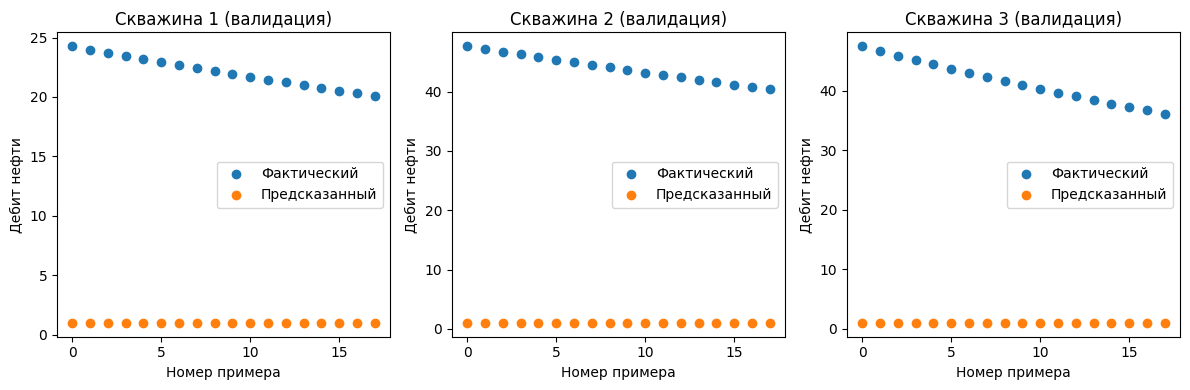

In [34]:
# Визуализация результатов для валидационной выборки
plt.figure(figsize=(12, 4))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.scatter(range(len(val_data.y)), val_data.y[:, i], label='Фактический')
    plt.scatter(range(len(pred_val)), pred_val[:, i], label='Предсказанный')
    plt.xlabel('Номер примера')
    plt.ylabel('Дебит нефти')
    plt.title(f'Скважина {i+1} (валидация)')
    plt.legend()
plt.tight_layout()
plt.show()

In [35]:
# Предсказание на валидационных данных
model.eval()
with torch.no_grad():
    pred_val = model(val_data)

NameError: name 'years_val' is not defined

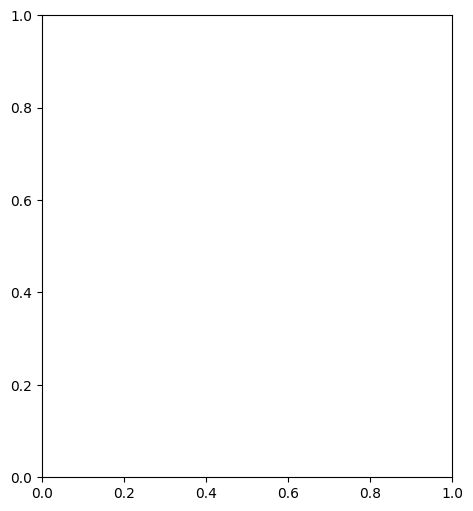

In [36]:
# Визуализация результатов для валидационной выборки
plt.figure(figsize=(18, 6))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.scatter(years_val, target_val[:, i], label='Фактический', color='blue')
    plt.scatter(years_val, pred_val[:, i], label='Предсказанный', color='red')
    plt.xlabel('Годы')
    plt.ylabel('Дебит нефти')
    plt.title(f'Скважина {i+1} (валидация)')
    plt.legend()
plt.tight_layout()
plt.show()